In [90]:
# ## install finrl library
# !pip install plotly==4.4.1
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
# !pip install PyPortfolioOpt

In [91]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [92]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [93]:
tickers = ["^TNX", "XU030.IS"]

In [94]:
df = YahooDownloader(start_date = '2000-01-01',
                           end_date = '2023-09-20',
                           ticker_list = tickers).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (11885, 8)


In [95]:
df.shape

(11885, 8)

In [96]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,6.498,6.603000,6.498000,6.548000,0,^TNX,0
1,2000-01-04,19368.000,22593.099609,19368.000000,22406.000000,0,XU030.IS,1
2,2000-01-04,6.530,6.548000,6.485000,6.485000,0,^TNX,1
3,2000-01-05,22406.000,22762.800781,20585.199219,21475.099609,0,XU030.IS,2
4,2000-01-05,6.521,6.599000,6.508000,6.599000,0,^TNX,2


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11885 entries, 0 to 11884
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    11885 non-null  object 
 1   open    11885 non-null  float64
 2   high    11885 non-null  float64
 3   low     11885 non-null  float64
 4   close   11885 non-null  float64
 5   volume  11885 non-null  int64  
 6   tic     11885 non-null  object 
 7   day     11885 non-null  int32  
dtypes: float64(4), int32(1), int64(1), object(2)
memory usage: 696.5+ KB


In [98]:
df['date'] = pd.to_datetime(df['date'])

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11885 entries, 0 to 11884
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11885 non-null  datetime64[ns]
 1   open    11885 non-null  float64       
 2   high    11885 non-null  float64       
 3   low     11885 non-null  float64       
 4   close   11885 non-null  float64       
 5   volume  11885 non-null  int64         
 6   tic     11885 non-null  object        
 7   day     11885 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(1)
memory usage: 696.5+ KB


In [100]:
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

In [101]:
df = df.sort_values(['date','tic'],ignore_index=True)

In [102]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,6.498,6.603000,6.498000,6.548000,0,^TNX,0
1,2000-01-04,19368.000,22593.099609,19368.000000,22406.000000,0,XU030.IS,1
2,2000-01-04,6.530,6.548000,6.485000,6.485000,0,^TNX,1
3,2000-01-05,22406.000,22762.800781,20585.199219,21475.099609,0,XU030.IS,2
4,2000-01-05,6.521,6.599000,6.508000,6.599000,0,^TNX,2


In [103]:
df.tic.value_counts()

tic
^TNX        5959
XU030.IS    5926
Name: count, dtype: int64

In [104]:
# Filter the DataFrame to keep only rows where the date is common for all tickers
df = df[df.groupby('date')['tic'].transform('nunique') == len(tickers)]

In [105]:
df.shape

(11454, 8)

In [106]:
df.tic.value_counts()

tic
XU030.IS    5727
^TNX        5727
Name: count, dtype: int64

In [107]:
df.head()

,date,open,high,low,close,volume,tic,day
1,2000-01-04,19368.000000,22593.099609,19368.000000,22406.000000,0,XU030.IS,1
2,2000-01-04,6.530000,6.548000,6.485000,6.485000,0,^TNX,1
3,2000-01-05,22406.000000,22762.800781,20585.199219,21475.099609,0,XU030.IS,2
4,2000-01-05,6.521000,6.599000,6.508000,6.599000,0,^TNX,2
5,2000-01-06,21475.099609,22006.800781,19998.500000,20136.500000,0,XU030.IS,3


In [108]:
# Perform Feature Engineering:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = config.INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


/usr/local/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:106: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


In [109]:
processed.isnull().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
tic             0
day             0
macd            0
boll_ub         0
boll_lb         0
rsi_30          0
cci_30          0
dx_30           0
close_30_sma    0
close_60_sma    0
turbulence      0
dtype: int64

In [110]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11454 entries, 0 to 11453
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          11454 non-null  object 
 1   open          11454 non-null  float64
 2   high          11454 non-null  float64
 3   low           11454 non-null  float64
 4   close         11454 non-null  float64
 5   volume        11454 non-null  int64  
 6   tic           11454 non-null  object 
 7   day           11454 non-null  int32  
 8   macd          11454 non-null  float64
 9   boll_ub       11454 non-null  float64
 10  boll_lb       11454 non-null  float64
 11  rsi_30        11454 non-null  float64
 12  cci_30        11454 non-null  float64
 13  dx_30         11454 non-null  float64
 14  close_30_sma  11454 non-null  float64
 15  close_60_sma  11454 non-null  float64
 16  turbulence    11454 non-null  float64
dtypes: float64(13), int32(1), int64(1), object(2)
memory usage: 1.4+ MB


In [111]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2000-01-04,19368.000000,22593.099609,19368.000000,22406.000000,0,XU030.IS,1,0.000000,23257.041762,20624.057847,0.0,66.666667,100.00000,22406.000000,22406.000000,0.0
1,2000-01-04,6.530000,6.548000,6.485000,6.485000,0,^TNX,1,0.000000,23257.041762,20624.057847,0.0,66.666667,100.00000,6.485000,6.485000,0.0
2,2000-01-05,22406.000000,22762.800781,20585.199219,21475.099609,0,XU030.IS,2,-20.885586,23257.041762,20624.057847,0.0,66.666667,100.00000,21940.549805,21940.549805,0.0
3,2000-01-05,6.521000,6.599000,6.508000,6.599000,0,^TNX,2,0.002558,6.703220,6.380780,100.0,66.666667,100.00000,6.542000,6.542000,0.0
4,2000-01-06,21475.099609,22006.800781,19998.500000,20136.500000,0,XU030.IS,3,-68.122275,23620.873919,19057.525820,0.0,-100.000000,57.40766,21339.199870,21339.199870,0.0


In [112]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 2, State Space: 21


In [113]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

In [114]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [115]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [116]:
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2018-04-01'
TEST_START_DATE = '2018-04-01'
TEST_END_DATE = '2023-09-20'

In [117]:
rebalance_window = 66 # rebalance_window is the number of days to retrain the model
validation_window = 22 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [118]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [119]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
| train/                |            |
|    entropy_loss       | -2.87      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 1599       |
|    policy_loss        | -0.489     |
|    reward             | 0.48816115 |
|    std                | 1.02       |
|    value_loss         | 0.0342     |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 224        |
|    iterations         | 1700       |
|    time_elapsed       | 37         |
|    total_timesteps    | 8500       |
| train/                |            |
|    entropy_loss       | -2.86      |
|    explained_variance | 0.0261     |
|    learning_rate      | 0.0007     |
|    n_updates          | 1699       |
|    policy_loss        | -0.399     |
|    reward             | -0.7822653 |
|    std                | 1.01       |
|    value_loss  

In [120]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,88,2018-04-02,2018-05-04,A2C,-0.008736,-0.621087,-0.654422
1,154,2018-07-10,2018-08-09,A2C,0.418099,-0.292302,0.138598
2,220,2018-10-18,2018-11-20,DDPG,-0.122874,-0.436576,0.0
3,286,2019-01-28,2019-02-28,PPO,0.215882,0.411323,0.215882
4,352,2019-05-06,2019-06-11,PPO,0.089006,0.135719,-0.663992
5,418,2019-08-19,2019-09-20,A2C,0.538997,-0.276332,0.0
6,484,2019-11-22,2019-12-26,A2C,0.589593,-0.118862,0.520531
7,550,2020-03-02,2020-04-01,DDPG,-0.768441,-0.539374,-0.300297
8,616,2020-06-10,2020-07-13,PPO,0.251632,0.470341,0.251632
9,682,2020-09-17,2020-10-19,A2C,0.632774,0.375887,0.0


In [121]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [122]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value,temp],ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.02353412126950952


In [123]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2018-05-04,NaN,2018-05-04
1,1000000.000000,2018-05-07,0.000000,2018-05-07
2,1000000.000000,2018-05-08,0.000000,2018-05-08
3,1000000.000000,2018-05-09,0.000000,2018-05-09
4,999998.667852,2018-05-10,-0.000001,2018-05-10


<Axes: >

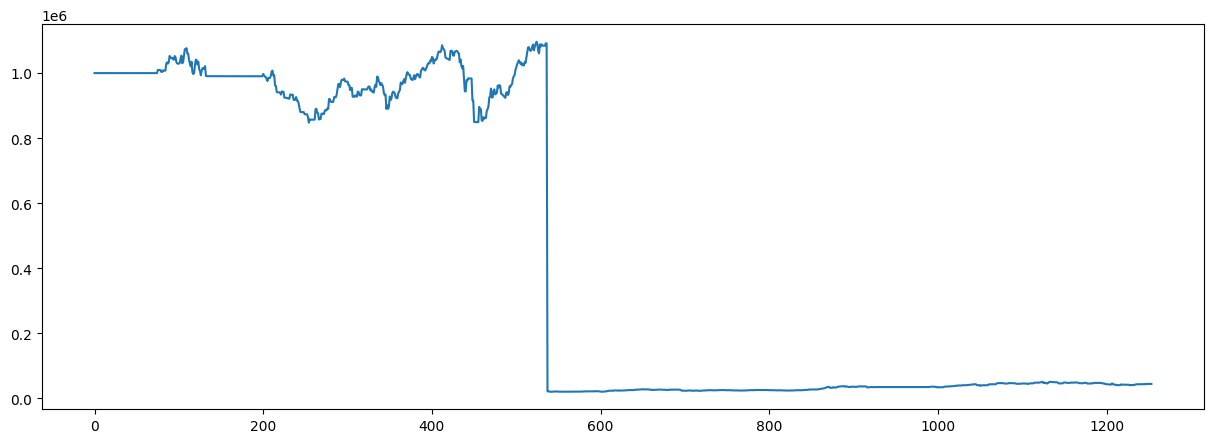

In [124]:
%matplotlib inline
df_account_value.account_value.plot()

In [125]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.464331
Cumulative returns    -0.955235
Annual volatility      0.491095
Sharpe ratio          -0.023534
Calmar ratio          -0.473211
Stability              0.640613
Max drawdown          -0.981235
Omega ratio            0.989195
Sortino ratio         -0.024829
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.160234
Daily value at risk   -0.061918
dtype: float64


In [126]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (1314, 8)
Annual return          0.075362
Cumulative returns     0.460610
Annual volatility      0.210795
Sharpe ratio           0.450952
Calmar ratio           0.203207
Stability              0.681708
Max drawdown          -0.370862
Omega ratio            1.094825
Sortino ratio          0.625152
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.930203
Daily value at risk   -0.026180
dtype: float64


In [127]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")
df_account_value.to_csv('df_account_value.csv')

df_dji:              date           dji
0     2018-05-04  1.000000e+06
1     2018-05-07  1.003908e+06
2     2018-05-08  1.004027e+06
3     2018-05-09  1.011542e+06
4     2018-05-10  1.019661e+06
...          ...           ...
1249  2023-07-20  1.393465e+06
1250  2023-07-21  1.396203e+06
1251  2023-07-24  1.382002e+06
1252  2023-07-25  1.372565e+06
1253  2023-07-26  1.394174e+06

[1254 rows x 2 columns]
df_dji:                       dji
date                    
2018-05-04  1.000000e+06
2018-05-07  1.003908e+06
2018-05-08  1.004027e+06
2018-05-09  1.011542e+06
2018-05-10  1.019661e+06
...                  ...
2023-07-20  1.393465e+06
2023-07-21  1.396203e+06
2023-07-24  1.382002e+06
2023-07-25  1.372565e+06
2023-07-26  1.394174e+06

[1254 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:          datadate
0     2018-04-02
1     2018-04-03
2     2018-04-04
3     2018-04-05
4     2018-04-06
...          ...
1308  2023-09-13
1309  2023-09-14
1310  2023-09-15
1311  2023-09-18
1312  2023-09-19

[1313 rows x 1 columns]
df_result_ensemble:                    ensemble
date                      
2018-05-04  1000000.000000
2018-05-07  1000000.000000
2018-05-08  1000000.000000
2018-05-09  1000000.000000
2018-05-10   999998.667852
...                    ...
2023-07-20    45047.764297
2023-07-21    44851.767767
2023-07-24    44827.773206
2023-07-25    44509.683869
2023-07-26    44764.774118

[1254 rows x 1 columns]
==============Compare to DJIA===========
result:                    ensemble           dji
date                                    
2018-05-04  1000000.000000  1.000000e+06
2018-05-07  1000000.000000  1.003908e+06
2018-05-08  1000000.000000  1.004027e+06
2018-05-09  1000000.000000  1.011542e+

<Figure size 1500x500 with 0 Axes>

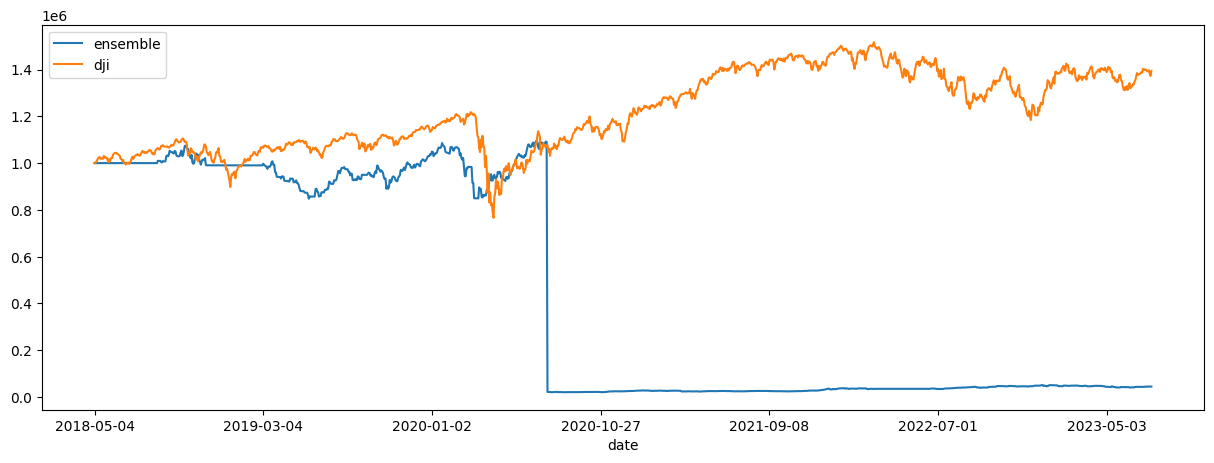

In [128]:


# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();